In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
# sampling

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
____________________________________________________________________________________________

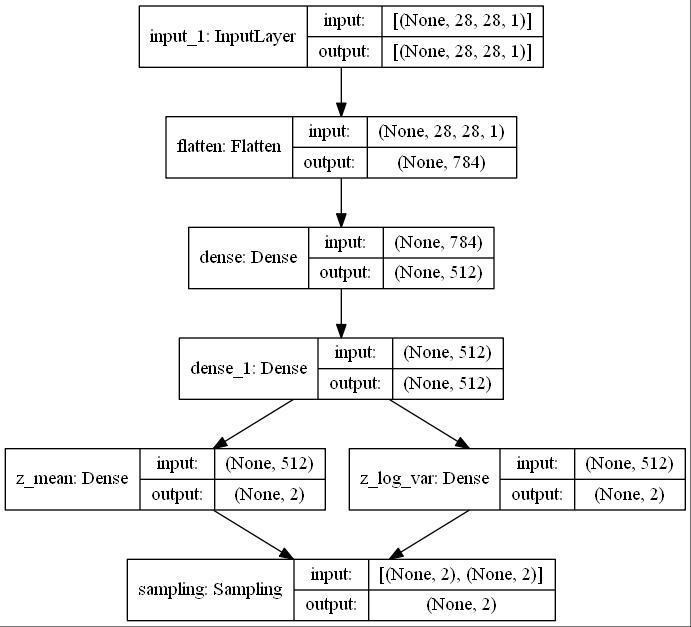

In [3]:
# encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))

#x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
#x = layers.Flatten()(x)

x = layers.Flatten()(encoder_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.jpg', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 1)         10        
Total params: 666,394
Trainable params: 666,394
Non-trainable params: 0
_____________________________________________________

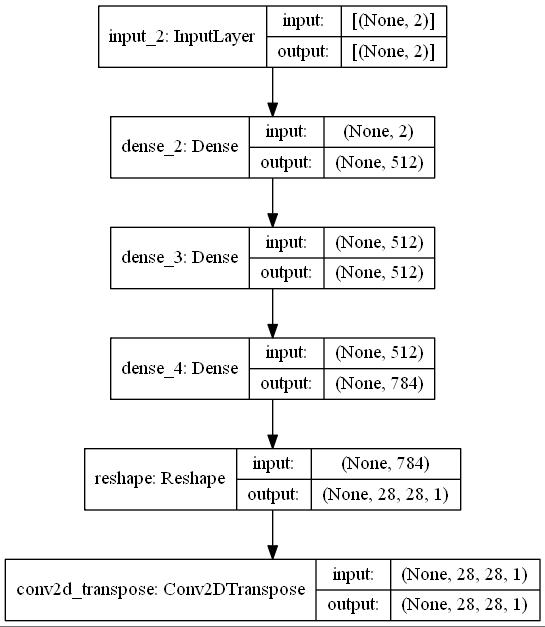

In [4]:
# decoder

latent_inputs = keras.Input(shape=(latent_dim,))

#x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding="same")(latent_inputs)
#x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding="same")(x)

x = layers.Dense(512, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(784, activation="relu")(x)
x = layers.Reshape((28, 28, 1))(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
plot_model(decoder,to_file='vae_mlp_decoder.jpg',show_shapes=True)

In [5]:
# variational autoencoder

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction
        
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reonstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
# train

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [8]:
row, col = 28, 28

def preprocess_image(path):
    img = load_img(path, grayscale=True, target_size=(row,col))
    a = img_to_array(img).astype('float32')/255.
    a = np.expand_dims(a, axis = 0)
    return a

In [9]:
if __name__ == '__main__':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if physical_devices:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)
            
    train_dir = glob.glob('dataset/train/0/*.jpg')
    #test_dir = glob.glob('dataset/test/0/*.jpg')
    
    X_train = np.vstack([preprocess_image(fn) for fn in train_dir])
    #X_test = np.vstack([preprocess_image(fn) for rn in test_dir])
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())

C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [13]:
    vae.fit(X_train, epochs=100, batch_size=128)

Epoch 1/100


NameError: in user code:

    C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\KBCI\anaconda3\envs\m8\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    <ipython-input-5-5ce80a492095>:33 train_step
        keras.losses.binary_crossentropy(data, reconstruction), axis(1, 2)

    NameError: name 'axis' is not defined


In [ ]:
    vae.save_weights('checkpoint/vae_mlp_mnist')

In [ ]:
# train check

def plot_latent_space(vae, n=30, figsize=15):
    #display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
            
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
    
plot_latent_space(vae)

In [ ]:
# test

In [ ]:
import tensorflow as tf
from mlp_VAE import encoder, decoder, VAE
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_shape = (28, 28, 1)

In [ ]:
row, cal = 28, 28

def preprocess_image(path):
    img = load_img(path, grayscale=True, target_size=(row,col))
    a = img_to_array(img).astype('float32')/255.
    a = np.expand_dims(a, axis = 0)
    return a

In [ ]:
if __name__ == '__main__':
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if physical_devices:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)

In [ ]:
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
    #vae.load_weights('checkpoint/vae_cnn_mnist')
    vae.load_weights('checkpoint/vae_mlp_mnist')

In [ ]:
    #test_data = preprocess_image('dataset/test/0/49903.jpg')
    test_data = preprocess_image('dataset/test/1/3.jpg')

In [ ]:
    pred_data = vae(data = test_data)

In [ ]:
    diff_data = abs(pred_data - test_data)
    #diff_data = abs(diff_data)
    image = np.asarray(diff_data).squeeze()
    plt.imshow(image)

In [ ]:
    anomaly_score = np.sum(diff_data)
    print(anomaly_score)